In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.preprocessing import text, sequence
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
import pickle
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,MaxPooling1D, Flatten
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [4]:
data = pd.read_csv('flipkart_com-ecommerce_sample.csv')

In [5]:
data.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."
5,c2a17313954882c1dba461863e98adf2,2016-03-25 22:59:23 +0000,http://www.flipkart.com/eternal-gandhi-super-s...,Eternal Gandhi Super Series Crystal Paper Weig...,"[""Eternal Gandhi Super Series Crystal Paper We...",PWTEB7H2E4KCYUE3,430.0,430.0,"[""http://img5a.flixcart.com/image/paper-weight...",False,Key Features of Eternal Gandhi Super Series Cr...,No rating available,No rating available,Eternal Gandhi,"{""product_specification""=>[{""key""=>""Model Name..."
6,ce5a6818f7707e2cb61fdcdbba61f5ad,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FVVKRBAXHB,1199.0,479.0,"[""http://img6a.flixcart.com/image/short/p/j/z/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
7,8542703ca9e6ebdf6d742638dfb1f2ca,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGYGHFUEXN,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/e/x...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
8,29c8d290caa451f97b1c32df64477a2c,2016-03-25 22:59:23 +0000,http://www.flipkart.com/dilli-bazaaar-bellies-...,"dilli bazaaar Bellies, Corporate Casuals, Casuals","[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH3DZBFR88SCK,699.0,

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [7]:
data1 = data[[ 'product_name', 'description', 'product_category_tree']]

In [8]:
data1 = data1.dropna(axis = 0)

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_name           19998 non-null  object
 1   description            19998 non-null  object
 2   product_category_tree  19998 non-null  object
dtypes: object(3)
memory usage: 624.9+ KB


In [10]:
data1.reset_index(inplace=True)

In [11]:
data1.head(554)

,index,product_name,description,product_category_tree
0,0,Alisha Solid Women's Cycling Shorts,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
1,1,FabHomeDecor Fabric Double Sofa Bed,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""Furniture >> Living Room Furniture >> Sofa B..."
2,2,AW Bellies,Key Features of AW Bellies Sandals Wedges Heel...,"[""Footwear >> Women's Footwear >> Ballerinas >..."
3,3,Alisha Solid Women's Cycling Shorts,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
4,4,Sicons All Purpose Arnica Dog Shampoo,Specifications of Sicons All Purpose Arnica Do...,"[""Pet Supplies >> Grooming >> Skin & Coat Care..."
...,...,...,...,...
549,549,Allen Solly Girl's Shift Dress,Allen Solly Girl's Shift Dress - Buy Blue Alle...,"[""Clothing >> Kids' Clothing >> Girls Wear >> ..."
550,550,Allen Solly Girl's Gathered Dress,Allen Solly Girl's Gathered Dress - Buy Red Al...,"[""Clothing >> Kids' Clothing >> Girls Wear >> ..."
551,551,Ozel Studio Casual Full Sleeve Printed Women's...,Ozel Studio Casual Full Sleeve Printed Women's...,"[""Clothing >> Women's Clothing >> Western Wear..."
552,552,Ozel Studio Casual Full Sleeve Solid Women's Top,Ozel Studio Casual Full Sleeve Solid Women's T...,"[""Clothing >> Women's Clothing >> Western Wear..."


In [12]:
re.sub('[^a-zA-Z>>]',' ' , data1.product_category_tree[4]).split('>>')[0].strip()

'Pet Supplies'

In [13]:
data1['description'] = data1['product_name'] + " " + data1['description'] 

In [14]:
data1 = data1.drop('product_name', axis=1)

In [15]:
data1.head(5)

,index,description,product_category_tree
0,0,Alisha Solid Women's Cycling Shorts Key Featur...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
1,1,FabHomeDecor Fabric Double Sofa Bed FabHomeDec...,"[""Furniture >> Living Room Furniture >> Sofa B..."
2,2,AW Bellies Key Features of AW Bellies Sandals ...,"[""Footwear >> Women's Footwear >> Ballerinas >..."
3,3,Alisha Solid Women's Cycling Shorts Key Featur...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
4,4,Sicons All Purpose Arnica Dog Shampoo Specific...,"[""Pet Supplies >> Grooming >> Skin & Coat Care..."


In [16]:
data1['description'][553]

"Gee & Bee Casual Printed Women's Kurti Gee & Bee Casual Printed Women's Kurti\n                         Price: Rs. 649\n\t\t\t\t\n\t\t\tGee & Bee Presents 100% cotton Womens Kurtis with premium qality fabric and in ozone free dyes\nGee & Bee Presents 100% cotton Womens Kurtis with premium qality fabric and in ozone free dyes"

In [17]:
data1['category'] = '1'
for i in range(0, len(data1)):
  data1['category'][i] = re.sub('[^a-zA-Z>>]',' ' , data1.product_category_tree[i]).split('>>')[0].strip()
data1 = data1.drop(columns=['index','product_category_tree'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data1.head()

,description,category
0,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
1,FabHomeDecor Fabric Double Sofa Bed FabHomeDec...,Furniture
2,AW Bellies Key Features of AW Bellies Sandals ...,Footwear
3,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
4,Sicons All Purpose Arnica Dog Shampoo Specific...,Pet Supplies


In [19]:
top_10 = data1['category'].value_counts()[:10].sort_values()
top_10 = list(top_10.index)
top_10

['Computers',
 'Kitchen   Dining',
 'Home Furnishing',
 'Beauty and Personal Care',
 'Home Decor   Festive Needs',
 'Automotive',
 'Mobiles   Accessories',
 'Footwear',
 'Jewellery',
 'Clothing']

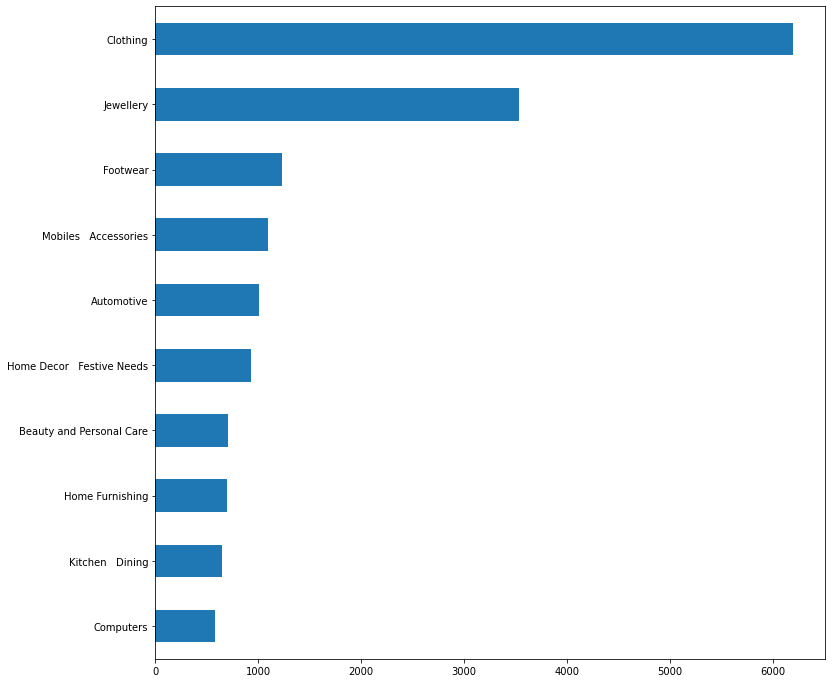

In [20]:
plt.figure(figsize=(12,12))
data1['category'].value_counts()[:10].sort_values().plot(kind ='barh')

In [21]:
data1 = data1[data1['category'].isin(top_10)][['description', 'category']]
data1.head()

,description,category
0,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
2,AW Bellies Key Features of AW Bellies Sandals ...,Footwear
3,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
6,Alisha Solid Women's Cycling Shorts Key Featur...,Clothing
8,"dilli bazaaar Bellies, Corporate Casuals, Casu...",Footwear


In [22]:
data1 = data1.reset_index()

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
def processed(data):
  corpus = []
  stemming = PorterStemmer()
  for i in range(0, len(data)):
    print(i)
    remove = re.sub('[^a-zA-Z]', ' ', data['description'][i])
    partial = remove.lower()
    filter = partial.split()
    
    filter = [stemming.stem(word) for word in filter if not word in stopwords.words('english')]
    filter = ' '.join(filter)
    corpus.append(filter)
  return corpus

In [ ]:
corpus = processed(data1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(corpus)

In [64]:
x_train,x_test,y_train,y_test = train_test_split(corpus,data1.category.values,test_size=0.2,random_state = 42)
maxf = 5000
maxl = 250

In [50]:
x_train[0]

'statu first love women minim bra statu first love women minim bra price rs statu women non pad bra avail differ color full support statu women non pad bra avail differ color full support'

In [28]:
tokenizer = text.Tokenizer(num_words=maxf)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_matrix(x_train, mode = 'tfidf')

x_test = tokenizer.texts_to_matrix(x_test, mode = 'tfidf')


In [29]:
x_train.shape

(13303, 5000)

In [30]:
x_test.shape

(3326, 5000)

In [70]:
y_test

array(['Jewellery', 'Footwear', 'Footwear', ..., 'Footwear', 'Clothing',
       'Beauty and Personal Care'], dtype=object)

In [71]:
encoder = preprocessing.LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.fit_transform(y_test)

In [72]:
y_testb = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_trainb = label_binarize(y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])

In [108]:
clf=MultinomialNB()
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print (clf.score(x_test, y_test))
predicted_result=clf.predict(x_test)
print(classification_report(y_test,predicted_result))

0.9953393971284673
0.9846662657847264
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       220
           1       0.95      0.93      0.94       149
           2       1.00      1.00      1.00      1252
           3       0.89      0.96      0.92       112
           4       0.99      0.98      0.99       245
           5       0.95      0.97      0.96       186
           6       0.97      0.99      0.98       128
           7       1.00      1.00      1.00       671
           8       1.00      0.93      0.96       133
           9       0.97      0.96      0.96       230

    accuracy                           0.98      3326
   macro avg       0.97      0.97      0.97      3326
weighted avg       0.99      0.98      0.98      3326



In [33]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter

In [109]:
y_pred = clf.predict_proba(x_test)

In [70]:
cm = metrics.confusion_matrix(y_test, predicted_result)
cm

array([[ 216,    0,    0,    0,    0,    0,    0,    0,    0,    4],
       [   0,  139,    0,    3,    1,    4,    1,    1,    0,    0],
       [   0,    0, 1251,    0,    0,    0,    0,    1,    0,    0],
       [   0,    0,    0,  108,    1,    0,    0,    1,    0,    2],
       [   0,    1,    3,    0,  241,    0,    0,    0,    0,    0],
       [   0,    4,    0,    1,    0,  181,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,  127,    0,    0,    0],
       [   0,    1,    0,    1,    0,    1,    0,  668,    0,    0],
       [   1,    1,    0,    1,    0,    3,    3,    0,  124,    0],
       [   2,    0,    0,    8,    0,    0,    0,    0,    0,  220]])

In [71]:
accuracy_score(y_test,predicted_result)

0.9846662657847264

In [111]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_testb.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [112]:
roc_auc

{0: 0.9994892583269918,
 1: 0.994825433643237,
 2: 0.9995139888040273,
 3: 0.9914436838830119,
 4: 0.9986467420463803,
 5: 0.9967082734059312,
 6: 0.9993062070043778,
 7: 0.9988032590422143,
 8: 0.9866672632096998,
 9: 0.9983232221098752,
 'micro': 0.9979920547593962}

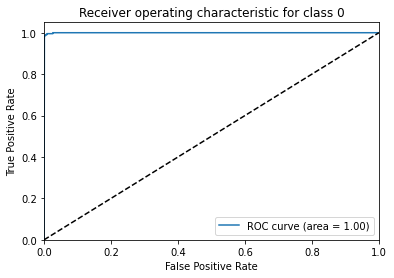

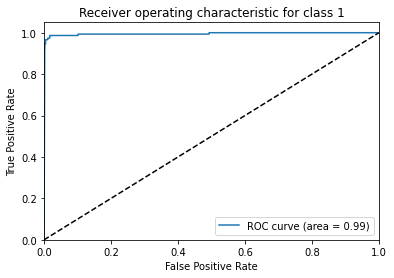

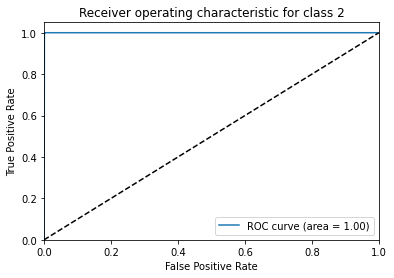

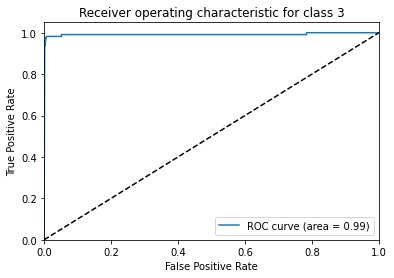

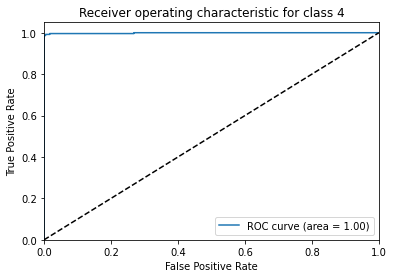

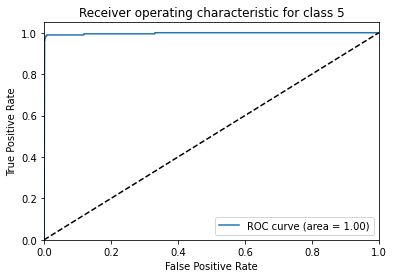

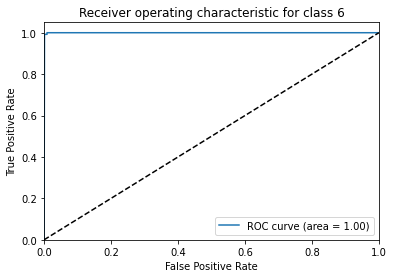

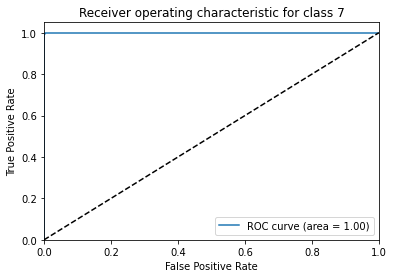

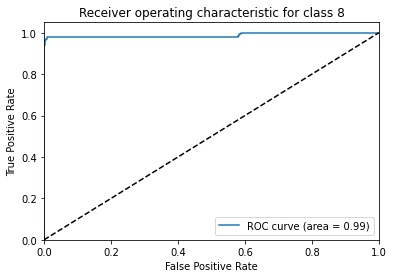

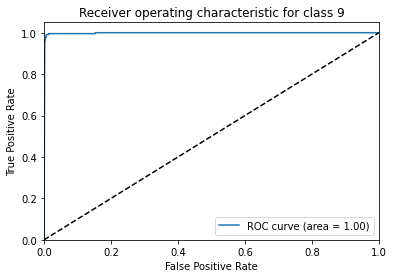

In [114]:
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [116]:
filename = 'NBClassifier.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [34]:
glove_vec = dict()
file = open('Data/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in file:
  values = line.split()
  word = values[0]
  vec = np.asarray(values[1:])
  glove_vec[word] = vec
file.close()

In [35]:
voc_size = len(tokenizer.word_index)+1
word_vec_mat = np.zeros((voc_size,100))
for word, index in tokenizer.word_index.items():
  vector = glove_vec.get(word)
  if vector is not None:
    word_vec_mat[index] = vector
  else:
    print(word)

necklac
sleev
qualiti
bangl
jewelleri
coverag
warranti
allur
dimens
showpiec
vehicl
durabl
voylla
dailyobject
artifici
polyest
embroid
suitabl
speedwav
karatcraft
sturdi
wedg
preciou
ensur
slightli
thelostpuppi
wardrob
gemston
grafion
synthet
blous
adroitz
printland
closur
elast
oviyon
enhanc
diamet
blueston
camisol
kadhai
destudio
rockmantra
daili
sunshad
flexibl
deterg
portabl
clariti
textur
georgett
voltag
prithish
safeti
smartpro
nighti
jewelri
summari
puriti
microwav
placket
headphon
easili
antiqu
enthopia
customis
lifestyl
perfectli
dishwash
nimya
homeehub
essenti
painstakingli
exquisit
ploomz
contemporari
fragranc
theskinmantra
dressberri
geometr
funki
fadeproof
sapphir
vaniti
stretchabl
turtl
earphon
fuson
sparkl
breathabl
artificti
hotpip
lapguard
neckti
akup
friendli
deodor
authent
viviti
consumpt
sukkhi
adhes
wirefre
navaksha
nucod
vaishali
nexu
xebac
quantiti
manirathnum
younki
glossi
foldabl
massag
multifunct
fanci
oxyglow
getabhi
yepm
washabl
dangl
rotat
moistur
churidar


In [65]:
tokenizer = text.Tokenizer(num_words=maxf)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxl)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxl)

In [66]:
batch_size = 24
epochs = 10
embed_size = 100

In [85]:
model = Sequential()
model.add(Embedding(voc_size, output_dim=embed_size, weights=[word_vec_mat], input_length=maxl, trainable=False))

model.add(LSTM(units=100 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.3))
model.add(LSTM(units=50 , recurrent_dropout = 0.1 , dropout = 0.25))
model.add(Dense(units = 16 , activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 100)          1161700   
_________________________________________________________________
lstm_20 (LSTM)               (None, 250, 100)          80400     
_________________________________________________________________
lstm_21 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_20 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                170       
Total params: 1,273,286
Trainable params: 111,586
Non-trainable params: 1,161,700
_____________________________________

In [ ]:
product_cat = model.fit(x_train, y_trainb, batch_size=batch_size,
validation_data = (x_test,y_testb) , epochs = epochs)
model.save(lstmClassifier.h5)

Epoch 1/10
555/555 [==============================] - 881s 2s/step - loss: 1.0806 - accuracy: 0.6582 - val_loss: 0.2797 - val_accuracy: 0.9080
Epoch 2/10
555/555 [==============================] - 872s 2s/step - loss: 0.2833 - accuracy: 0.9191 - val_loss: 0.1348 - val_accuracy: 0.9654
Epoch 3/10
555/555 [==============================] - 870s 2s/step - loss: 0.1806 - accuracy: 0.9536 - val_loss: 0.1330 - val_accuracy: 0.9627
Epoch 4/10
555/555 [==============================] - 853s 2s/step - loss: 0.1435 - accuracy: 0.9648 - val_loss: 0.1307 - val_accuracy: 0.9630
Epoch 5/10
555/555 [==============================] - 857s 2s/step - loss: 0.1909 - accuracy: 0.9480 - val_loss: 0.0849 - val_accuracy: 0.9775
Epoch 6/10
553/555 [============================>.] - ETA: 3s - loss: 0.1488 - accuracy: 0.9626